## Polynomial curve fitting 

We start with a simple example. Lets take a funcion $sin(2\pi x)$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
example = lambda x : np.sin(2 * np.pi * x)

(-10.0, 110.0)

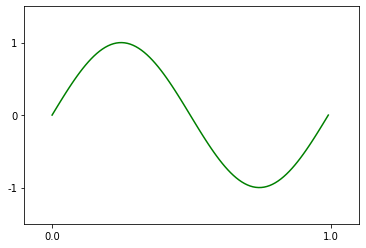

In [3]:
true = [example(x) for x in np.linspace(0, 1, 100)]
plt.plot(true, c='g')
plt.xticks(np.linspace(0, 100, 2), np.linspace(0, 1, 2))
plt.yticks(np.linspace(-1, 1, 3), np.linspace(-1, 1, 3).astype(int))
plt.ylim(-1.5, 1.5)
plt.xlim(-10, 110)

Sadly in practice you will never know this true underlying function. To mimic this we add a gaussian error to our data sample 

In [4]:
input_size = 10
input_ = np.linspace(0.01,1, input_size)

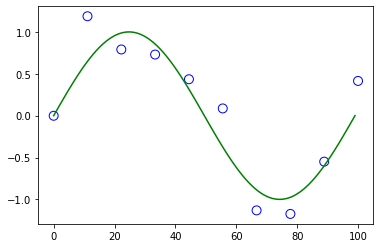

In [5]:
true_data = np.array([example(x) for x in input_])
gaussian_error = np.random.normal(0, 0.3, input_size)
training_data = true_data + gaussian_error

plt.plot(true, c='g')
plt.scatter(np.linspace(0,100, input_size), training_data, s=80, facecolor='none', edgecolors='blue')

For now we are going to approximate this sinus wave by fitting a $M$th polynomial function

$$
    y(x, w) = \sum_{j=0}^{M}w_jx^j
$$

A standard method for calculating the optimal $w$ is bone by minimizing the error function named sum of squares

$$
    E(w) = \frac{1}{2}\sum_{i=1}^N(y(x_n,w) - t_n)^2
$$

To solve this we can find the derivative of $w_i$ (note the partial derivative) and set to zero. First we will do this for $M=0$ (or only the intercept)

$$
    \frac{dE}{dw_0} = \sum_{i=1}^{N}(\sum_{j=0}^{M}w_jx^j - t_n)x^0 \\
    \sum_{j=0}^{M}w_jx^j x^0 = t_nx^0
$$

Since $M=0$ and anything to the power 0 is 1 we can greatly simplify this equation

$$
    w_0 = \frac{\sum_{i=1}^{N} t_n}{N}
$$

Meaning that when you pick a zero order polynomial you just end up with the mean

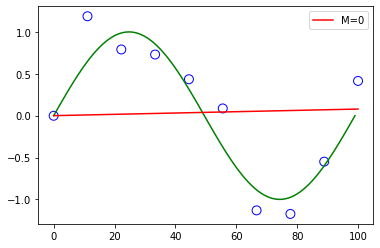

In [6]:
plt.plot(true, c='g')
input_ = np.linspace(0,100, input_size)
plt.scatter(input_, training_data, s=80, facecolor='none', edgecolors='blue')
plt.plot([0,100], [0, training_data.sum() / training_data.size], c='r', label='M=0')
plt.legend()
plt.show()

For the generalization it is easier to leave the coupled linear equations and use a matrix notation and solve using the pseudo inverse (described in chapter 3). To calculate this you first transform the values on the x axis into a matrix having all the values to the Nth polynomial

In [41]:
def get_polynomials(data_size, M):
    X = np.zeros((data_size, M + 1))

    for i in range(M + 1):
        X[:,i] = np.power(np.linspace(0.01,1, data_size), i).reshape(-1,)
        
    return X

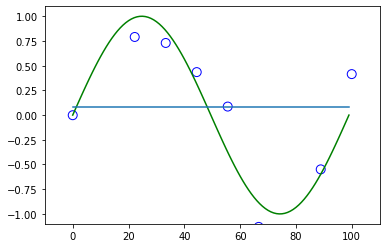

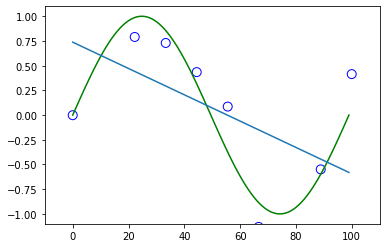

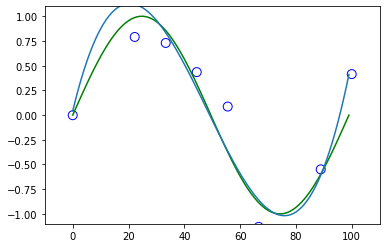

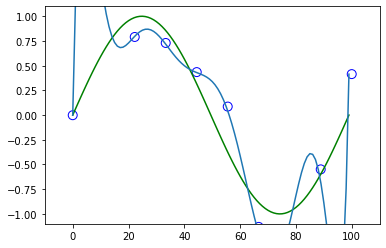

In [115]:
for m in [0, 1, 3, 9]:
    X = get_polynomials(training_data.size, m)
    w_star = np.linalg.inv(X.T @ X) @ X.T @ training_data
    
    X = get_polynomials(100, m)
    plt.plot(true, c='g')
    plt.scatter(np.linspace(0,100, training_data.size), training_data, s=80, facecolor='none', edgecolors='blue')
    plt.plot((X @ w_star.reshape(-1,1)).flatten())
    plt.ylim(-1.1, 1.1)
    plt.xlim(-10, 110)
    plt.show()

What this shows is that with a higher order polynomial overfitting occurs. 3 seems about right 